# **Adversarial Attack**


## set up environment

In [ ]:
!pip install pytorchcv
!pip install torchattacks

# download
!gdown --id 1fHi1ko7wr80wXkXpqpqpOxuYH1mClXoX -O data.zip

# unzip
!unzip ./data.zip
!rm ./data.zip

     |████████████████████████████████| 532 kB 5.3 MB/s 
     |████████████████████████████████| 102 kB 3.9 MB/s 
Downloading...
From: https://drive.google.com/uc?id=1fHi1ko7wr80wXkXpqpqpOxuYH1mClXoX
To: /content/data.zip
100% 490k/490k [00:00<00:00, 72.2MB/s]
Archive:  ./data.zip
   creating: data/
   creating: data/deer/
 extracting: data/deer/deer13.png    
 extracting: data/deer/deer6.png     
 extracting: data/deer/deer11.png    
 extracting: data/deer/deer2.png     
 extracting: data/deer/deer10.png    
 extracting: data/deer/deer16.png    
 extracting: data/deer/deer9.png     
 extracting: data/deer/deer20.png    
 extracting: data/deer/deer15.png    
 extracting: data/deer/deer19.png    
 extracting: data/deer/deer5.png     
 extracting: data/deer/deer14.png    
 extracting: data/deer/deer4.png     
 extracting: data/deer/deer8.png     
 extracting: data/deer/deer12.png    
 extracting: data/deer/deer1.png     
 extracting: data/deer/deer7.png     
 extracting: data/deer/deer17

In [ ]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

batch_size = 8

# the mean and std are the calculated statistics from cifar_10 dataset
cifar_10_mean = (0.491, 0.482, 0.447) # mean for the three channels of cifar_10 images
cifar_10_std = (0.202, 0.199, 0.201) # std for the three channels of cifar_10 images

# convert mean and std to 3-dimensional tensors for future operations
mean = torch.tensor(cifar_10_mean).to(device).view(3, 1, 1)
std = torch.tensor(cifar_10_std).to(device).view(3, 1, 1)

epsilon = 8/255/std

root_test = './data' # directory for storing benign images
# benign images: images which do not contain adversarial perturbations
# adversarial images: images which include adversarial perturbations

cuda


## Dataset and DataLoader

In [ ]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar_10_mean, cifar_10_std)
])

class TestCifar10(Dataset):
    def __init__(self, data_dir, transform):
        self.images = []
        self.labels = []
        self.names = []
        
        for i, class_dir in enumerate(sorted(glob.glob(f'{data_dir}/*'))):
            images = sorted(glob.glob(f'{class_dir}/*'))
            # list add opt
            self.images += images
            self.labels += ([i] * len(images))
            self.names += [os.path.relpath(imgs, data_dir) for imgs in images]
        self.transform = transform
    def __getitem__(self, idx):
        image = self.transform(Image.open(self.images[idx]))
        label = self.labels[idx]
        return image, label
    def __getname__(self):
        return self.names
    def __len__(self):
        return len(self.images)

test_set = TestCifar10(root_test, transform=transform)
test_names = test_set.__getname__()
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

print(f'number of images = {test_set.__len__()}')

number of images = 200


## load pre trained models
All are pre-trained in cifar10 


Model list is available [here](https://pypi.org/project/pytorchcv/).

In [ ]:
from pytorchcv.model_provider import get_model as ptcv_get_model

models = []
models.append(ptcv_get_model('resnet110_cifar10', pretrained=True).to(device))
models.append(ptcv_get_model('preresnet110_cifar10', pretrained=True).to(device))
models.append(ptcv_get_model('pyramidnet110_a84_cifar10', pretrained=True).to(device))
models.append(ptcv_get_model('nin_cifar10', pretrained=True).to(device))
models.append(ptcv_get_model('wrn28_10_cifar10', pretrained=True).to(device))

# to evaluate the performance of model on benign images
def epoch_benign(model, loader, loss_fn):
    model.eval()
    train_acc, train_loss = 0.0, 0.0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        yp = model(x)
        loss = loss_fn(yp, y)
        train_acc += (yp.argmax(dim=1) == y).sum().item()
        # loss use mean (not sum), loss manually sum here
        train_loss += loss.item() * x.shape[0]
    return train_acc / len(loader.dataset), train_loss / len(loader.dataset)


for model in models:
  benign_acc, benign_loss = epoch_benign(model, test_loader, nn.CrossEntropyLoss())
  print(f'benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

benign_acc = 0.95000, benign_loss = 0.22678
benign_acc = 0.95000, benign_loss = 0.28506
benign_acc = 0.95500, benign_loss = 0.25732


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


benign_acc = 0.91500, benign_loss = 0.30362
benign_acc = 0.96000, benign_loss = 0.17589


## Ensemble Adversarial Attack
Delving into Transferable Adversarial Examples and Black-box Attacks
[here](https://arxiv.org/abs/1611.02770)

for non-target attack implemented here:

$$ arg\min_{x'} -L(x',y) + \lambda d(x,x') $$
$$ L(x',y) = log(1 - \sum_{i=1}^{k} \alpha_iJ_i(x')1_y ) $$
where $J_i()$ is the softmax output, $1_y$ is the one-hot label

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

def Ensemble_Adversarial_Attack(models, images, labels, num_classes, distortion_weight=0.04, steps=100, lr=0.01):
  r"""
  'Delving into Transferable Adversarial Examples and Black-box Attacks'
  [https://arxiv.org/abs/1611.02770]

  Distance Measure : L2

  Arguments:
      models (nn.Module): a list of model to ensemble adversarial examples.
      distortion_weight (float): weight of distance between image and adversrial example in loss function. (Default: 0)
      steps (int): number of steps. (Default: 100)
      lr (float): learning rate of the Adam optimizer. (Default: 0.01)

  Shape:
      - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`, `H = height` and `W = width`. It must have a range [0, 1].
      - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
      - output: :math:`(N, C, H, W)`.

  """
  images = images.clone().detach().to(device)
  labels = labels.clone().detach().to(device)
  one_hot_labels = torch.eye(num_classes)[labels].to(device)
  # print("images:{} images:{} one_hot_labels:{}".format(images.shape, labels.shape, one_hot_labels.shape))

  num_models = len(models)
  num_images = images.shape[0]
  # print("num_models:{} num_images:{}".format(num_models, num_images))

  adv_images = images.clone().detach()
  adv_images.requires_grad = True

  optimizer = optim.Adam([adv_images], lr=lr)

  MSELoss = nn.MSELoss(reduction='none')
  softmax = nn.Softmax(dim=1)
  flatten = nn.Flatten()

  for step in range(steps):
    # print("step:{} steps:{}".format(step, steps))

    for i, model in enumerate(models):
      # train_acc = 0.0
      outputs = model(adv_images)
      outputs = softmax(outputs)

      # train_acc += (outputs.argmax(dim=1) == labels).sum().item()
      # train_acc = train_acc / num_images
      # print("model:{} acc:{:3.6f}".format(model.__class__.__name__, train_acc))

      if i == 0:
        ensemble_outputs = outputs
      else:
        ensemble_outputs = ensemble_outputs + outputs

    ensemble_outputs = ensemble_outputs / num_models
    # print(ensemble_outputs)

    current_L2 = MSELoss(flatten(adv_images), flatten(images)).sum(dim=1)
    L2_loss = current_L2.sum()
    # print(MSELoss(flatten(adv_images), flatten(images)))
    # print(current_L2)

    mask = one_hot_labels.ge(0.5)
    current_ensemble = torch.log(1 - torch.masked_select(ensemble_outputs, mask))
    
    # print(one_hot_labels)
    # print(torch.mul(ensemble_outputs, one_hot_labels))
    # print(torch.masked_select(ensemble_outputs, mask))

    ensemble_loss = current_ensemble.sum()
    # ensemble_loss.backward() # fsgm
    cost = distortion_weight * L2_loss - ensemble_loss
    # print(cost)

    optimizer.zero_grad()
    cost.backward()
    # print(adv_images.grad)
    optimizer.step()

    # adv_images = adv_images + epsilon * adv_images.grad.detach().sign()
    # adv_images = torch.clip(adv_images, min=images-epsilon, max=images+epsilon)

  return adv_images


In [ ]:
# generate adv examples here
for i, (image, label) in enumerate(test_loader):
  image, label = image.to(device), label.to(device)
  adv_image = Ensemble_Adversarial_Attack(models, image, label, num_classes=10)
  # store adversarial examples
  adv_ex = ((adv_image) * std + mean).clamp(0, 1) # to 0-1 scale
  adv_ex = (adv_ex * 255).clamp(0, 255) # 0-255 scale
  adv_ex = adv_ex.detach().cpu().data.numpy().round() # round to remove decimal part
  adv_ex = adv_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
  adv_examples = adv_ex if i == 0 else np.r_[adv_examples, adv_ex]

## save and test

In [ ]:
# create directory which stores adversarial examples
def create_dir(data_dir, adv_dir, adv_examples, test_names):
    if os.path.exists(adv_dir) is not True:
        _ = shutil.copytree(data_dir, adv_dir)
    for example, name in zip(adv_examples, test_names):
        im = Image.fromarray(example.astype(np.uint8)) # image pixel value should be unsigned int
        im.save(os.path.join(adv_dir, name))

create_dir(root_test, 'ema', adv_examples, test_names)

In [ ]:
adv_set = TestCifar10('./ema', transform=transform)
adv_loader = DataLoader(adv_set, batch_size=batch_size, shuffle=False)

# loss and acc
for model in models:
  benign_acc, benign_loss = epoch_benign(model, test_loader, nn.CrossEntropyLoss())
  print(f'model:{model.__class__.__name__} benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

  adv_acc, adv_loss = epoch_benign(model, adv_loader, nn.CrossEntropyLoss())
  print(f'model:{model.__class__.__name__} adv_acc = {adv_acc:.5f}, adv_loss = {adv_loss:.5f}')

model:CIFARResNet benign_acc = 0.95000, benign_loss = 0.22678
model:CIFARResNet adv_acc = 0.07000, adv_loss = 5.23130
model:CIFARPreResNet benign_acc = 0.95000, benign_loss = 0.28506
model:CIFARPreResNet adv_acc = 0.07500, adv_loss = 5.01161
model:CIFARPyramidNet benign_acc = 0.95500, benign_loss = 0.25732
model:CIFARPyramidNet adv_acc = 0.04000, adv_loss = 5.55630
model:CIFARNIN benign_acc = 0.91500, benign_loss = 0.30362
model:CIFARNIN adv_acc = 0.09500, adv_loss = 2.15768
model:CIFARWRN benign_acc = 0.96000, benign_loss = 0.17589
model:CIFARWRN adv_acc = 0.06500, adv_loss = 5.52997


## Visualization

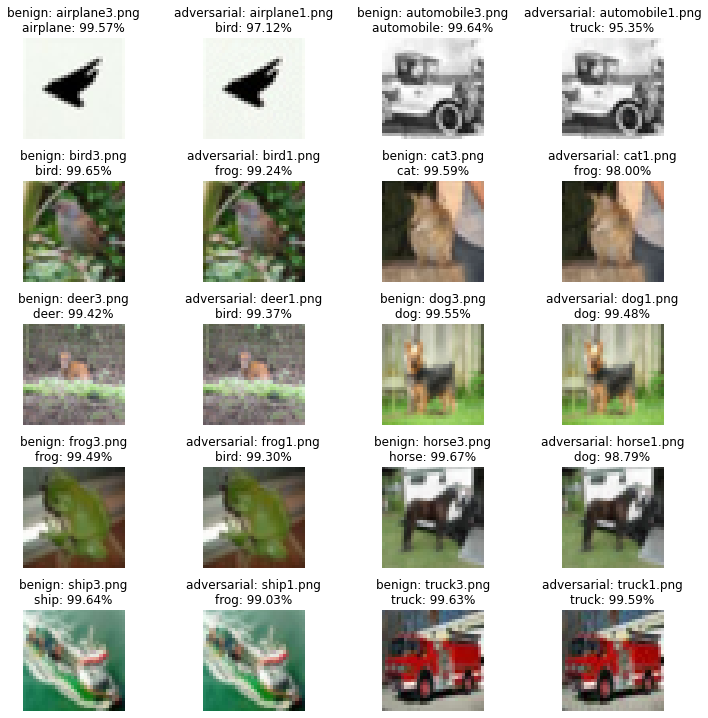

In [ ]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}3.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}3.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./ema/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()

In [ ]:
%cd ema
!tar zcvf ../ema.tgz *
%cd ..

/content/ema
airplane/
airplane/airplane8.png
airplane/airplane4.png
airplane/airplane5.png
airplane/airplane19.png
airplane/airplane17.png
airplane/airplane11.png
airplane/airplane13.png
airplane/airplane12.png
airplane/airplane16.png
airplane/airplane7.png
airplane/airplane20.png
airplane/airplane1.png
airplane/airplane6.png
airplane/airplane18.png
airplane/airplane10.png
airplane/airplane2.png
airplane/airplane14.png
airplane/airplane15.png
airplane/airplane9.png
airplane/airplane3.png
automobile/
automobile/automobile18.png
automobile/automobile13.png
automobile/automobile11.png
automobile/automobile19.png
automobile/automobile4.png
automobile/automobile15.png
automobile/automobile9.png
automobile/automobile2.png
automobile/automobile3.png
automobile/automobile12.png
automobile/automobile16.png
automobile/automobile6.png
automobile/automobile17.png
automobile/automobile5.png
automobile/automobile7.png
automobile/automobile8.png
automobile/automobile14.png
automobile/automobile1.png

# Transferability
the adv examples generated by resnet110, preresnet110, pyramidnet110_a84, nin, wrn28_10 (5 models included) will apply on RoR model (excluded in the Ensemble Adversarial Attack)

This is called transferability of adversarial examples.

In [ ]:
from pytorchcv.model_provider import get_model as ptcv_get_model

transfer_models = []
transfer_models.append(ptcv_get_model('ror3_110_cifar10', pretrained=True).to(device))

for model in transfer_models:
  benign_acc, benign_loss = epoch_benign(model, test_loader, nn.CrossEntropyLoss())
  print(f'model:{model.__class__.__name__} benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

  transfer_acc, transfer_loss = epoch_benign(model, adv_loader, nn.CrossEntropyLoss())
  print(f'model:{model.__class__.__name__} transfer_acc = {transfer_acc:.5f}, transfer_loss = {transfer_loss:.5f}')


model:CIFARRoR benign_acc = 0.95500, benign_loss = 0.28892
model:CIFARRoR transfer_acc = 0.63000, transfer_loss = 1.01639


# small-scale transfer
in this section, we will reinforce the examples above

## FSGM
[here](https://arxiv.org/abs/1412.6572)

$ x' = x + \epsilon \cdot sign(\nabla _xL(x',y)) $

In [ ]:
# perform fgsm attack
def fgsm(model, images, labels, num_classes, epsilon=epsilon):
  softmax = nn.Softmax(dim=1)
  one_hot_labels = torch.eye(num_classes)[labels].to(device)
  adv_images = images.detach().clone() # initialize x_adv as original benign image x
  adv_images.requires_grad = True # need to obtain gradient of x_adv, thus set required grad
  outputs = softmax(model(adv_images))
  
  mask = one_hot_labels.ge(0.5)
  current_loss = torch.log(1 - torch.masked_select(outputs, mask))

  loss = current_loss.sum()
  loss.backward() # calculate gradient
  # fgsm: use gradient ascent on x_adv to maximize loss
  adv_images = adv_images + epsilon * adv_images.grad.detach().sign()
  return adv_images

loss and acc if only fgsm is used

In [ ]:
for model in models:
  for i, (image, label) in enumerate(test_loader):
    image, label = image.to(device), label.to(device)
    fgsm_image = fgsm(model, image, label, num_classes=10)
    # store fsgm examples
    fgsm_ex = ((fgsm_image) * std + mean).clamp(0, 1) # to 0-1 scale
    fgsm_ex = (fgsm_ex * 255).clamp(0, 255) # 0-255 scale
    fgsm_ex = fgsm_ex.detach().cpu().data.numpy().round() # round to remove decimal part
    fgsm_ex = fgsm_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
    fgsm_examples = fgsm_ex if i == 0 else np.r_[fgsm_examples, fgsm_ex]

In [ ]:
create_dir(root_test, 'fsgm', fgsm_examples, test_names)

fgsm_set = TestCifar10('./fsgm', transform=transform)
fgsm_loader = DataLoader(fgsm_set, batch_size=batch_size, shuffle=False)

In [ ]:
for model in transfer_models:
  benign_acc, benign_loss = epoch_benign(model, test_loader, nn.CrossEntropyLoss())
  print(f'model:{model.__class__.__name__} benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

  fgsm_acc, fgsm_loss = epoch_benign(model, fgsm_loader, nn.CrossEntropyLoss())
  print(f'model:{model.__class__.__name__} fgsm_acc = {fgsm_acc:.5f}, fgsm_loss = {fgsm_loss:.5f}')


model:CIFARRoR benign_acc = 0.95500, benign_loss = 0.28892
model:CIFARRoR fgsm_acc = 0.71500, fgsm_loss = 0.97620


reinforce examples above (Ensemble Adversarial Attack) by fgsm 

In [ ]:
for model in models:
  for i, (image, label) in enumerate(adv_loader):
    image, label = image.to(device), label.to(device)
    transfer_image = fgsm(model, image, label, num_classes=10)
    # store transfered examples
    transfer_ex = ((transfer_image) * std + mean).clamp(0, 1) # to 0-1 scale
    transfer_ex = (transfer_ex * 255).clamp(0, 255) # 0-255 scale
    transfer_ex = transfer_ex.detach().cpu().data.numpy().round() # round to remove decimal part
    transfer_ex = transfer_ex.transpose((0, 2, 3, 1)) # transpose (bs, C, H, W) back to (bs, H, W, C)
    transfer_examples = transfer_ex if i == 0 else np.r_[transfer_examples, transfer_ex]

In [ ]:
create_dir(root_test, 'transfer', transfer_examples, test_names)

transfer_set = TestCifar10('./transfer', transform=transform)
transfer_loader = DataLoader(transfer_set, batch_size=batch_size, shuffle=False)

In [ ]:
for model in transfer_models:
  benign_acc, benign_loss = epoch_benign(model, test_loader, nn.CrossEntropyLoss())
  print(f'model:{model.__class__.__name__} benign_acc = {benign_acc:.5f}, benign_loss = {benign_loss:.5f}')

  transfer_acc, transfer_loss = epoch_benign(model, transfer_loader, nn.CrossEntropyLoss())
  print(f'model:{model.__class__.__name__} transfer_acc = {transfer_acc:.5f}, transfer_loss = {transfer_loss:.5f}')


model:CIFARRoR benign_acc = 0.95500, benign_loss = 0.28892
model:CIFARRoR transfer_acc = 0.37000, transfer_loss = 2.29271


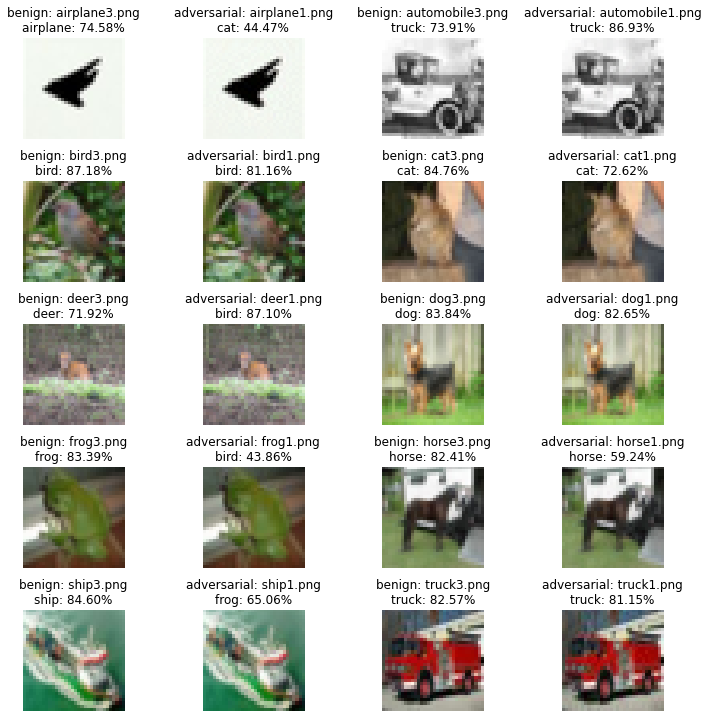

In [ ]:
import matplotlib.pyplot as plt

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10, 20))
cnt = 0
for i, cls_name in enumerate(classes):
    path = f'{cls_name}/{cls_name}3.png'
    # benign image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./data/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'benign: {cls_name}3.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
    # adversarial image
    cnt += 1
    plt.subplot(len(classes), 4, cnt)
    im = Image.open(f'./ema/{path}')
    logit = model(transform(im).unsqueeze(0).to(device))[0]
    predict = logit.argmax(-1).item()
    prob = logit.softmax(-1)[predict].item()
    plt.title(f'adversarial: {cls_name}1.png\n{classes[predict]}: {prob:.2%}')
    plt.axis('off')
    plt.imshow(np.array(im))
plt.tight_layout()
plt.show()